In [1]:
import pandas as pd
import numpy as np
from googletrans import Translator
import string
import time
import seaborn as sns
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
import gender_guesser.detector as gender
import matplotlib.pyplot as plt
import json
import numbers
import multiprocessing
from itertools import product
from collections import Counter
RND_STATE = 515991

%matplotlib inline

/Users/bulhakovdmytro/anaconda3/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


## 0. Config

In [2]:
max_string_length = 500
translate_delay = 0
translate_chunk = 1000
input_csv = '123.csv'
output_csv = 'data_converted.csv'

In [3]:
def log_progress(sequence, every=None, size=None, name='Processed'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

In [4]:
def chunks(l, n):
    for i in range(0, len(l), n):
        yield l[i:i + n]

## 1. Loading data

### 1.1 Loading and decoding data

In [ ]:
data = pd.read_csv(input_csv, sep=',', encoding='utf8')
data = data.loc[:, ~data.columns.str.contains('^Unnamed')]
data_length_start = len(data)
print('Initial length: {0}'.format(data_length_start))
data.describe()

## 2. Preprocessing

### 2.1 Removing nans and unnecessary columns

In [ ]:
data = data.drop(['picture', 'link', 'from_id', 'post_id'], axis=1)
data[['shares']] = data[['shares']].fillna(value=0)
data = data.dropna(how='all')
data = data.dropna(subset=['message'])
print('Removed {0} elements'.format(data_length_start - len(data)))
print('New length is {0}'.format(len(data)))

### 2.2 Removing emojis, links and numbers

emojis

In [ ]:
data['message'] = data['message'].str.replace(u'[^\U00000000-\U0000d7ff\U0000e000-\U0000ffff]', '')
data['description'] = data['description'].str.replace(u'[^\U00000000-\U0000d7ff\U0000e000-\U0000ffff]', '')

links

In [ ]:
data['message'] = data['message'].str.replace(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '')
data['description'] = data['description'].str.replace(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '')

numbers

In [ ]:
data['message'] = data['message'].str.replace(r'\b\d+\b','')
data['description'] = data['description'].str.replace(r'\b\d+\b','')

special chars

In [ ]:
data['message'] = data['message'].str.replace('"', '')
data['message'] = data['message'].str.replace('#', '')

data['description'] = data['description'].str.replace('"', '')
data['description'] = data['description'].str.replace('#', '')

### 2.3 Removing advertisements

In [ ]:
data = data[~data['from'].str.contains("Visit-Petersburg", na=False)]
print('Removed {0} elements'.format(data_length_start - len(data)))
print('New length is {0}'.format(len(data)))
data.describe()

### 2.4 Stripping texts and converting types

In [ ]:
def convert_column_int(column):
    converted = []
    for value in column.values:
        if str(value).isdigit():
            converted.append(value)
        else:
            converted.append(0)
    return converted

In [ ]:
data['message'] = data['message'].apply(lambda x: x[:max_string_length].strip())
data['description'] = data['description'].apply(lambda x: str(x)[:max_string_length].strip())

In [ ]:
data['shares'] = convert_column_int(data['shares'])
data[['shares']] = data[['shares']].apply(pd.to_numeric)

### 2.5 Translating texts into english

In [ ]:
def translate_big_text(texts_source, dest = 'en', chunk_size = 500, delay=0):
    translated = []
    chunks_list = list(chunks(texts_source, chunk_size))
    number_of_errors = 0
    for chunk in log_progress(chunks_list):
        # renew translator
        Translator().translate(u''.join('Hello!'), dest=dest).text
        trans_res, err_num = translate_big_text_internal(chunk)
        number_of_errors += err_num
        translated.extend(trans_res) 
        if delay > 0:
            print('Waiting {0} sec'.format(delay))
            time.sleep(delay)
            
    print('Number of errors: ', number_of_errors)
    return translated

In [ ]:
def translate(text, dest='en'):
    translator = Translator()
    translated = ''
    try:
        translated = translator.translate(u''.join(text), dest=dest).text
    except Exception as e:
        print(e)
    return translated

In [ ]:
def translate_big_text_internal(texts_source, dest='en'):
    with multiprocessing.Pool(processes=30) as pool:
        results = pool.starmap(translate, product(texts_source))
        
    return results, results.count('')

In [ ]:
msg_translations = translate_big_text(data['message'].values, chunk_size = translate_chunk, delay = translate_delay)

In [ ]:
data['message'] = msg_translations

In [ ]:
descr_translations = translate_big_text(data['description'].values, chunk_size = translate_chunk, delay = translate_delay)

In [ ]:
data['description'] = descr_translations

In [ ]:
names_translations = translate_big_text(data['from'].values, chunk_size = translate_chunk, delay = translate_delay)

In [ ]:
data['from'] = names_translations

## 2.7 Moving all words to lower case

In [ ]:
data["message"] = data["message"].map(lambda x: x if type(x)!=str else x.lower())
data["description"] = data["description"].map(lambda x: x if type(x)!=str else x.lower())

### 2.8 Tokenizing sentences

In [ ]:
data['message'] = data['message'].apply(lambda x: nltk.word_tokenize(str(x)))
data['description'] = data['description'].apply(lambda x: nltk.word_tokenize(str(x)))

### 2.9 Removing stopwords and punctuation

In [19]:
stop_words = stopwords.words('english')
stop_words += (['.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}', '\n', '/n', '-', '#', 'visitpetersburg', 'visitrussia', 'russia', 'the', 'is', 'a'])

In [ ]:
data['message'] = data['message'].apply(lambda x: list(filter(lambda y: y not in stop_words, x)))
data['description'] = data['description'].apply(lambda x: list(filter(lambda y: y not in stop_words, x)))

In [ ]:
data['message'] = data['message'].apply(lambda x: " ".join(x))
data['description'] = data['description'].apply(lambda x: " ".join(x))

### 2.10 Saving data to file

In [6]:
def save_csv():
    data.to_csv(output_csv, index=False)

In [7]:
def parse_csv(series):
    values = series.values
    parsed = []
    for value in values:
        parsed.append(json.loads(value.replace("'",'"')))
    return parsed

In [8]:
def load_csv():
    loaded_data = pd.read_csv(output_csv, sep=',', encoding='utf8')
    loaded_data['message_sentiment_vader'] = parse_csv(loaded_data['message_sentiment_vader'])
    loaded_data['description_sentiment_vader'] = parse_csv(loaded_data['description_sentiment_vader'])
    return loaded_data

In [ ]:
save_csv()

# 3. Processing data

## 3.1 Trying to guess gender by name

In [ ]:
detector = gender.Detector(case_sensitive=False)

In [ ]:
data['from_gender'] = [detector.get_gender((str(name)).split(' ')[0]) for name in data['from'].values]

In [ ]:
data['from_gender'].replace([0],['unknown'],inplace=True)

## 3.1 Getting sentiments by Vader algorithm

In [ ]:
sid = SentimentIntensityAnalyzer()
message_sent = []
descr_sent = []
data['message'].apply(lambda x: message_sent.append(sid.polarity_scores((x))));
data['description'].apply(lambda x: descr_sent.append(sid.polarity_scores((x))));
data['message_sentiment_vader'] = message_sent
data['description_sentiment_vader'] = descr_sent

In [63]:
def get_message_sentiment(series, border_line=0.2):
    values = series.values
    parsed_values = []
    for value in values:
        if value['neg'] >= border_line:
            parsed_values.append('negative')
        elif value['pos'] >= border_line:
            parsed_values.append('positive')
        else:
            parsed_values.append('neutral')
    return parsed_values

In [ ]:
data['message_sentiment_vader_parsed'] = get_message_sentiment(data['message_sentiment_vader'])
data['description_sentiment_vader_parsed'] = get_message_sentiment(data['description_sentiment_vader'])

In [ ]:
save_csv()

## 3.2 Plotting stats 

In [37]:
data = load_csv()

### 3.2.1 Shares per gender

In [10]:
data.groupby(['from_gender']).sum()

,shares
from_gender,
andy,1
female,2166
male,6877
mostly_female,0
mostly_male,512
unknown,227183


#### 3.2.1.1 Row data

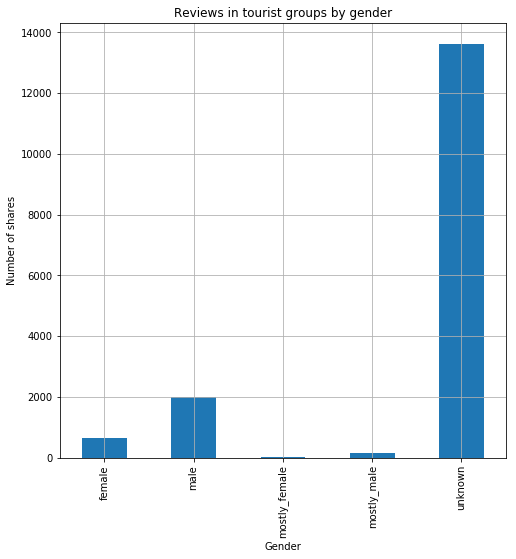

In [11]:
groups = data.groupby(['from_gender']).size()
groups = groups.drop(['andy'], axis=0)
ax = groups.plot(kind = 'bar', grid = True, title = 'Reviews in tourist groups by gender', figsize=(8, 8))
ax.set_xlabel('Gender');
ax.set_ylabel('Number of shares');

#### 3.2.1.2 Only genders

In [12]:
groups = data.groupby(['from_gender']).size()
groups = groups.drop(['andy', 'unknown'], axis=0)
groups['female'] += groups['mostly_female']
groups['male'] += groups['mostly_male']
groups = groups.drop(['mostly_female', 'mostly_male'], axis=0)

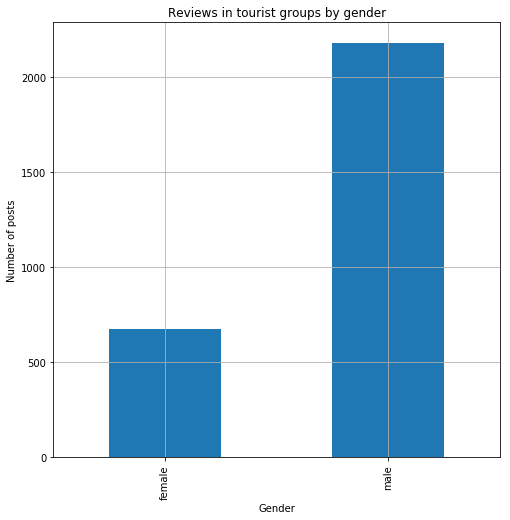

In [13]:
ax = groups.plot(kind = 'bar', grid = True, title = 'Reviews in tourist groups by gender', figsize=(8, 8))
ax.set_xlabel('Gender');
ax.set_ylabel('Number of posts');

### 3.2.2 Messages sentiments

#### 3.2.2.1 Just sentiments

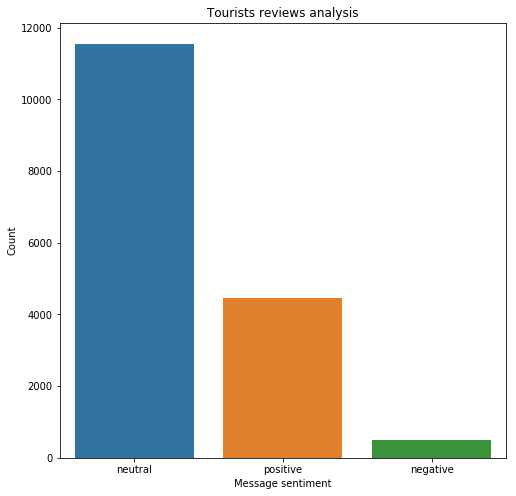

In [14]:
plt.figure(figsize=(8, 8))
ax = sns.countplot(x = data['message_sentiment_vader_parsed'])
ax.set_title('Tourists reviews analysis')
ax.set_xlabel('Message sentiment')
ax.set_ylabel('Count')
plt.show()

#### 3.2.2.2 Sentiments multiplied to shares

In [15]:
groups = data.groupby(['message_sentiment_vader_parsed']).size()
neg_shares = np.sum(data[data['message_sentiment_vader_parsed'] == 'negative']['shares'])
neu_shares = np.sum(data[data['message_sentiment_vader_parsed'] == 'neutral']['shares'])
neu_shares = np.sum(data[data['message_sentiment_vader_parsed'] == 'positive']['shares'])

groups['negative'] *= neg_shares
groups['neutral'] *= neu_shares
groups['positive'] *= neu_shares

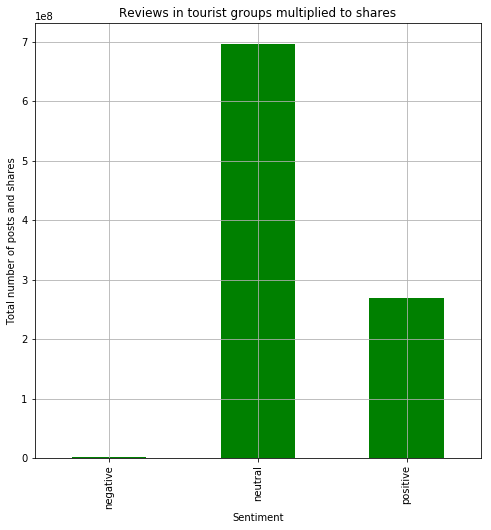

In [16]:
ax = groups.plot(kind = 'bar', grid = True, title = 'Reviews in tourist groups multiplied to shares', figsize=(8, 8), color='green')
ax.set_xlabel('Sentiment');
ax.set_ylabel('Total number of posts and shares');

#### 3.2.2.3 Sentiments by gender

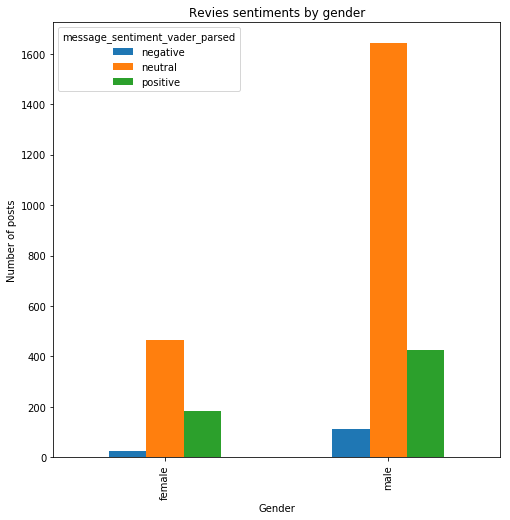

In [17]:
data_tmp = data.copy()
data_tmp = data_tmp.replace({"from_gender": {'mostly_female': 'female', 'mostly_male': 'male', 'andy': 'unknown'}})
data_tmp = data_tmp[data_tmp['from_gender'] != 'unknown']
ax = pd.crosstab(data_tmp['from_gender'], 
                 data_tmp['message_sentiment_vader_parsed']).plot.bar(title = 'Revies sentiments by gender', figsize=(8, 8))
ax.set_xlabel('Gender');
ax.set_ylabel('Number of posts');

### 3.2.3 Words

#### 3.2.3.1 Most common words

In [38]:
all_strings = " ".join(map(str, data['message'].values)) + " ".join(map(str, data['description'].values))
all_words = nltk.word_tokenize(all_strings)
stop_words += (['/', "'s", "''", '...', '..', '''``''', '//', '.-', '–', '&', '$', '%', '’', '--', '@'])
all_words = list(filter(lambda y: y not in stop_words, all_words))
counted_words = pd.DataFrame(Counter(all_words).most_common(), columns=['word', 'count'])

In [43]:
counted_words.head(25)[1:]

,word,count
1,yakutia,2341
2,russian,2302
3,moscow,2023
4,petersburg,1941
5,st.,1711
6,kaliningrad,1298
7,yakutsk,1288
8,year,1287
9,tour,1208
10,photo,1177


Plot

In [51]:
top25 = counted_words.head(25)[1:]

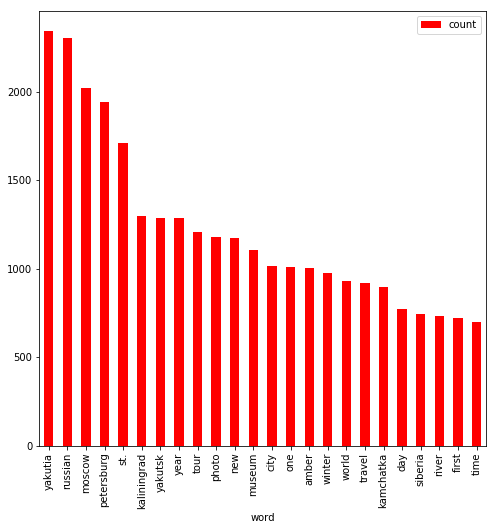

In [52]:
top25.plot.bar(x='word', y='count', figsize=(8, 8), color='red')

#### 3.2.3.2 Most common negative words

In [56]:
counted_words_sent = counted_words.copy()

In [50]:
sid = SentimentIntensityAnalyzer()

sid.polarity_scores('cock')

{'compound': -0.1531, 'neg': 1.0, 'neu': 0.0, 'pos': 0.0}

In [69]:
sentiments = []
counted_words_sent['word'].apply(lambda x: sentiments.append(sid.polarity_scores((x))));
counted_words_sent['word_tmp'] = sentiments
counted_words_sent['sentiment'] = get_message_sentiment(counted_words_sent['word_tmp'])
counted_words_sent = counted_words_sent.drop(['word_tmp'], axis=1)

Negative

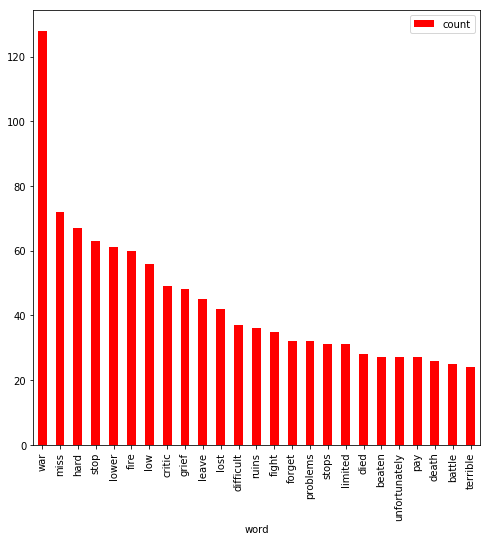

In [76]:
negative = counted_words_sent[counted_words_sent['sentiment'] == 'negative'].head(25)
negative.plot.bar(x='word', y='count', figsize=(8, 8), color='red')

Positive

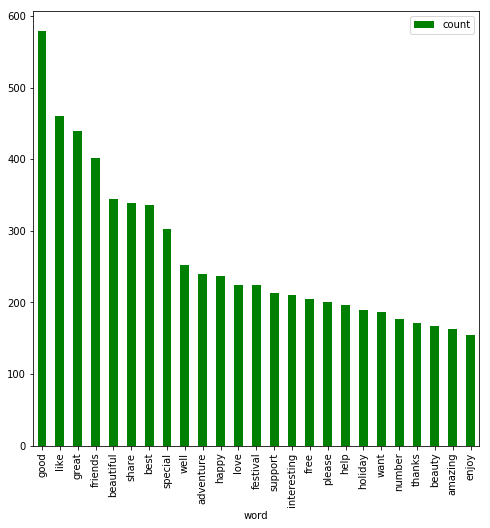

In [77]:
negative = counted_words_sent[counted_words_sent['sentiment'] == 'positive'].head(25)
negative.plot.bar(x='word', y='count', figsize=(8, 8), color='green')